<a href="https://colab.research.google.com/github/alby-beep/Scene-text-detection/blob/main/comparing_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 
from google.colab.patches import cv2_imshow 
from skimage import data,io,filters
from skimage.color import rgb2gray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(42, 88, 3)


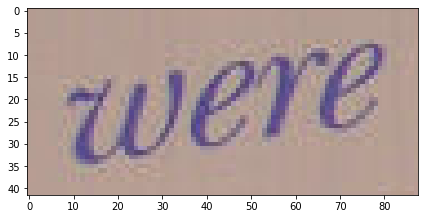

In [ ]:
img=cv2.imread("/content/drive/My Drive/project/used images here/img3/e.png")
print(img.shape)
io.imshow(img)

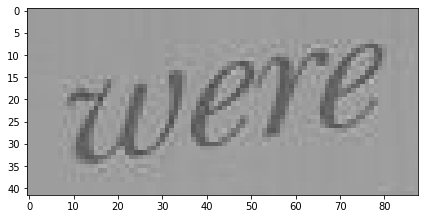

In [ ]:
#convert img to gray
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
io.imshow(gray)

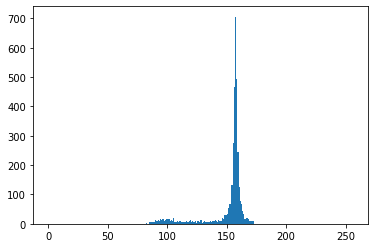

In [ ]:
plt.hist(gray.ravel(),256,[0,256]) 
plt.show()

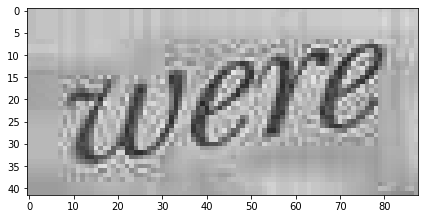

In [ ]:
clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_img=clahe.apply(gray)
io.imshow(cl_img)

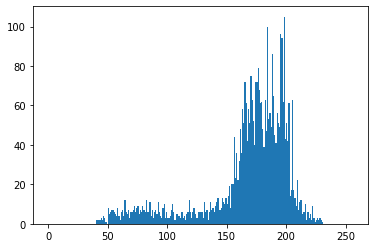

True

In [ ]:
src_path = "/content/drive/My Drive/project/"
#show histogram by applying clahe

plt.hist(cl_img.ravel(),256,[0,256]) 
plt.show()
cv2.imwrite(src_path + "cl_img.jpg", cl_img)

In [ ]:
# load and show an image with Pillow
from PIL import Image
# Open the image form working directory
image = Image.open('/content/drive/My Drive/project/cl_img.jpg')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image

JPEG
(88, 42)
L


True

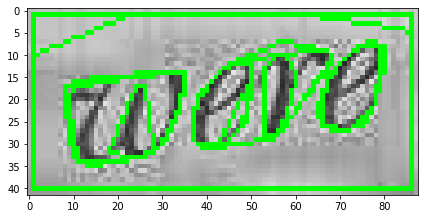

In [ ]:
#mser image
src_path = "/content/drive/My Drive/project/"
#ret,thresh = cv2.threshold(vis,127,255,0)
mser = cv2.MSER_create()
vis=cv2.cvtColor(cl_img,cv2.COLOR_GRAY2RGB)
#gray = cv2.cvtColor(cl_img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
#vis = cl_img.copy()
regions, _ = mser.detectRegions(cl_img)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
io.imshow(vis)
cv2.imwrite(src_path + "vis.jpg", vis)

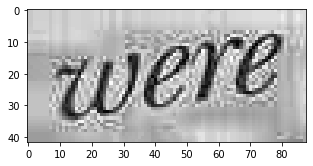

In [ ]:
img = rgb2gray(cl_img)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")

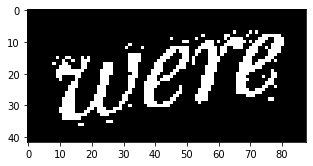

In [ ]:
# binarize the image using adaptive algorithm threshold_sauvola
from skimage.morphology import binary_closing
from skimage.filters import threshold_otsu, threshold_sauvola

window_size=21
thresh_sauvola = threshold_sauvola(img, window_size)
binary_sauvola = img < thresh_sauvola
plt.figure(figsize=(5,5))
plt.imshow(binary_sauvola, cmap="gray")

0


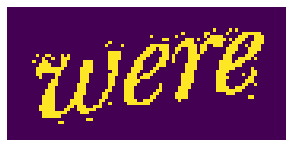

In [ ]:
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.patches as mpatches
label_image = label(binary_sauvola)
region_props = regionprops(label_image)
fig, ax = plt.subplots(figsize=(5,5))
bounding_boxes = []
for index, region in enumerate(region_props):
    strokeWidthValues = distance_transform_edt(region.image)
    strokeWidthMetric = np.std(strokeWidthValues)/np.mean(strokeWidthValues)
    should_clean = strokeWidthMetric < 0.4
if not should_clean:
        expansionAmountY = 0.02
        expansionAmountX = 0.03
        minr, minc, maxr, maxc = region.bbox
        
        minr = np.floor((1-expansionAmountY) * minr)
        minc = np.floor((1-expansionAmountX) * minc)
        maxr = np.ceil((1+expansionAmountY) * maxr)
        maxc = np.ceil((1+expansionAmountX) * maxc)

        bounding_boxes.append([minr, minc, maxr, maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)   
ax.set_axis_off()
print(len(bounding_boxes))
ax.imshow(binary_sauvola)
plt.show()

number_of_checks: 0
time_taken: 0.00016999244689941406


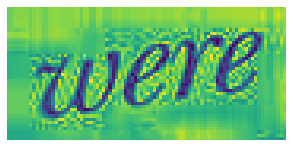

(42, 88)

In [ ]:

# https://stackoverflow.com/questions/306316/determine-if-two-rectangles-overlap-each-other
# now its time to merge the overlappiong bouding boxes.
import time

# minr, minc, maxr, maxc
def is_overlapping(box1, box2):
#     if (RectA.minc < RectB.maxc && RectA.maxc > RectB.minc &&
#      RectA.minr > RectB.maxr && RectA.maxr < RectB.minr )
    if box1[1] < box2[3] and box1[3] > box2[1] and box1[0] < box2[2] and box1[2] > box2[0]:
        return True
    return False

def is_almost_in_line(box1, box2):
    centroid_b1 = [int((box1[0]+box1[2])/2), int((box1[1]+box1[3])/2)]
    centroid_b2 = [int((box2[0]+box2[2])/2), int((box2[1]+box2[3])/2)]
    if (centroid_b2[0]-centroid_b1[0]) == 0:
        return True
    
    angle = (np.arctan(np.abs((centroid_b2[1]-centroid_b1[1])/(centroid_b2[0]-centroid_b1[0])) )*180)/np.pi
    if angle > 80:
        return True
    
    return False

#print(is_overlapping([1,1,3,3],[2,2,4,4]))
def combine_boxes(box1, box2):
    minr = np.min([box1[0],box2[0]])
    minc = np.min([box1[1],box2[1]])
    maxr = np.max([box1[2],box2[2]])
    maxc = np.max([box1[3],box2[3]])
    return [minr, minc, maxr, maxc]

#print(combine_boxes([1,1,3,3],[2,2,4,4]))
#combine overlapping boxes

# sort the bounding_boxes by their distance from Y Axis
# df = pd.DataFrame(bounding_boxes, columns = ["minr", "minc", "maxr", "maxc"])
# df = df.sort_values(["maxr", "maxc"], ascending = (True, True))

# bounding_boxes = df.values

# bounding_boxes = np.array(bounding_boxes)
# bounding_boxes = bounding_boxes[bounding_boxes[:,1].argsort()]

def group_the_bounding_boxes(bounding_boxes):
    stime = time.time()
    number_of_checks = 0
    box_groups = []
    dont_check_anymore = []
    for iindex, box1 in enumerate(bounding_boxes):
        if iindex in dont_check_anymore:
            continue
                
        group_size = 0
        bigger_box = box1
            
        for jindex, box2 in enumerate(bounding_boxes):
            if jindex in dont_check_anymore:
                continue
                
            if jindex == iindex:
                continue
                
            number_of_checks+=1
                    
            if is_overlapping(bigger_box, box2) and is_almost_in_line(bigger_box, box2):
                bigger_box = combine_boxes(bigger_box, box2)
                dont_check_anymore.append(jindex)
                group_size += 1
                
        if group_size > 0:
            # check if this group overlaps any other 
            # and combine it there otherwise make a new box.
            combined_with_existing_box = False
            for kindex, box3 in enumerate(box_groups):
                if is_overlapping(bigger_box, box3):
                    bigger_box = combine_boxes(bigger_box, box3)
                    box_groups[kindex] = bigger_box
                    combined_with_existing_box = True
                    break
                    
            if not combined_with_existing_box:
                box_groups.append(bigger_box)
                
        else:
            dont_check_anymore.append(iindex)
                
    print("number_of_checks:", number_of_checks)
    print("time_taken:", str(time.time() - stime))
    return box_groups


box_groups = group_the_bounding_boxes(bounding_boxes)

fig, ax = plt.subplots(figsize=(5,5))

# minr, minc, maxr, maxc
for box in box_groups:
    minr = box[0]
    minc = box[1]
    maxr = box[2]
    maxc = box[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
        
ax.axis("off")
ax.imshow(img)
plt.savefig(src_path + "img.jpg")
plt.show()
img.shape   


In [ ]:

!sudo apt-get update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!sudo pip install pytesseract
#Checking the installation.
!tesseract --version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
te

In [ ]:
import pytesseract


In [ ]:
text = pytesseract.image_to_string(img)
print(text)

qere



In [ ]:
!pip install gTTS
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 
  
# This module is imported so that we can  
# play the converted audio 
import os 

In [ ]:
# Language in which you want to convert 
language = 'en'
  
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
myobj = gTTS(text=text, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("/content/drive/My Drive/project/welcome.mp3") 
  
# Playing the converted file 
os.system("mpg321 /content/drive/My Drive/project/welcome.mp3") 

32512